# Access UP42 assets with PySTAC

[UP42](https://up42.com/) is a platform for accessing data from various geospatial providers.

* [SpatioTemporal Asset Catalog](https://stacspec.org/en/) (STAC) is a specification designed to establish a standard in geospatial data.
* [PySTAC](https://pystac.readthedocs.io/en/stable/) is a library for working with STAC.

This tutorial explains how to get STAC collections and STAC items associated with the UP42 assets in your storage and visualize them on a map. For more information, see [UP42's introduction to STAC](https://docs.up42.com/developers/api-assets/stac-about).

1. [Import libraries](#import)
2. [Create an UP42 access token](#token)
3. [Create a PySTAC-Client connection](#pystac-client)
4. [Get STAC collections](#collections)
5. [Get STAC items](#items)
6. [Make a detailed STAC item search](#search)
7. [Download and visualize results](#download-visualize)

## Import libraries <a class="anchor" id="import"></a>

In [2]:
import up42
import requests, base64

import pystac_client
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

from zipfile import ZipFile

## Create an UP42 access token <a class="anchor" id="token"></a>

1. [Find project credentials](#credentials)
2. [Generate an access token](#access)

### Find project credentials <a class="anchor" id="credentials"></a>

Each API call is made at a [project](https://docs.up42.com/processing-platform/projects) level.

1. Go to [Projects](https://console.up42.com/projects) and select an existing project or create a new one.
2. Go to the **Developers** tab in the project and copy the values of **Project API Key** and **Project ID**.
3. Copy and paste the values in the cell below.

In [3]:
PROJ_ID="your-project-id"
PROJ_KEY="your-project-key"

### Generate an access token <a class="anchor" id="access"></a>

The cell below creates a basic token by joining the project ID and its API key and encoding the combination to Base64 format. After that, it uses the created basic token to generate an access token.

In [4]:
def get_auth_token_prod(proj_id, proj_key):
    """Authentication based on UP42 project ID and project API key"""
    project_api_key = f"{proj_id}:{proj_key}"
    b64_val = base64.b64encode(project_api_key.encode()).decode()
    AUTH_URL = "https://api.up42.com/oauth/token"
    req_headers = {
        "Authorization": f"Basic {b64_val}",
        "Content-Type":"application/x-www-form-urlencoded",
    }
    req_body = {
        "grant_type":"client_credentials"
    }
    response = requests.post(AUTH_URL, data=req_body, headers=req_headers)
    return response.json()['data']['accessToken']

In [5]:
def create_auth_token(proj_id, proj_key, env):
    if (env == "prod"):
        UP42_signed_token = get_auth_token_prod(PROJ_ID, PROJ_KEY)
    return UP42_signed_token

## Create a PySTAC-Client connection <a class="anchor" id="pystac-client"></a>

In [6]:
def create_pystac_client(url, proj_id, proj_key, env):
    UP42_signed_token = create_auth_token(proj_id, proj_key, env)
    UP42_client = pystac_client.Client.open(
        url=url,
        headers= {
            'Authorization': f"Bearer {UP42_signed_token}",
        }
    )
    return UP42_client

In [7]:
PROD_URL = "https://api.up42.com"
CATALOG_URL = "/v2/assets/stac"
UP42_stac_catalog_url = PROD_URL + CATALOG_URL

In [8]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")

## Get STAC collections <a class="anchor" id="collections"></a>

A STAC collection is an UP42 asset you received after a completed order. An order can produce multiple STAC collections. A STAC collection contains different storage characteristics — for example, a [geospatial collection](https://docs.up42.com/data/datasets) name, a producer name, a corresponding UP42 asset ID.

For more information on STAC collections, see [Intro to STAC](https://stacspec.org/en/tutorials/intro-to-stac/#STAC-Collection) and [STAC Collection Specification](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md).

In [12]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")
UP42_client_stac_collections = list(UP42_client.get_collections())
len(UP42_client_stac_collections)

13

The cell below retrieves the following information about your STAC collections:
* A STAC collection title
* A STAC Collection ID
* A respective UP42 order ID
* A respective UP42 asset ID

In [13]:
for stac_collection in UP42_client_stac_collections[:3]: # Displays only the first 3 results
    print('------------ COLLECTION -------------')
    print('Title:              ', stac_collection.title)
    print('STAC Collection ID: ', stac_collection.id)
    current_stac_collection = getattr(stac_collection, 'extra_fields')
    print('Asset ID:           ', current_stac_collection['up42-system:asset_id'])
    if('up42-order:id' in current_stac_collection):
        print(f"Order ID:            {current_stac_collection['up42-order:id']}")
    print('------------ END -------------')

stac_collection_id_asset = UP42_client_stac_collections[0].id # Selects the first collection to get its items later

------------ COLLECTION -------------
Title:               DS_PHR1A_202210261023104_FR1_PX_E013N52_0614_01724
STAC Collection ID:  e532a6a8-c769-4243-a8a6-8bd8259e7cbc
Asset ID:            0610c93f-bef8-4625-9dce-a3275e0db645
------------ END -------------
------------ COLLECTION -------------
Title:               PNEO4_202210010944137_PMS-FS_ORT
STAC Collection ID:  0ac91365-07a7-4a58-b804-ecbd8075068d
Asset ID:            28a9cc6d-4314-4803-8f2d-db7fa68376cc
------------ END -------------
------------ COLLECTION -------------
Title:               DS_PHR1B_202210201019328_FR1_PX_E013N52_0314_05014
STAC Collection ID:  936d7c76-1e6e-44d3-87c1-6596c3da3da4
Asset ID:            ed60f358-379a-4fff-b9a9-30dc586416a8
------------ END -------------


You can also get information about a particular STAC collection by using its ID.

In [14]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")
client_single_stac_collection = UP42_client.get_collection(stac_collection_id_asset)
client_single_stac_collection

ID: e532a6a8-c769-4243-a8a6-8bd8259e7cbc
Title: DS_PHR1A_202210261023104_FR1_PX_E013N52_0614_01724
Description: Very high-resolution 50cm Pleiades images acquired daily on a global basis. The datasets are available starting from 2012.
Providers: AIRBUS DS GEO (producer) AIRBUS DS GEO (processor)
assets: {}
"stac_extensions: ['https://api.up42.com/stac-extensions/up42-system/v1.0.0/schema.json', 'https://api.up42.com/stac-extensions/up42-product/v1.0.0/schema.json']"
title: DS_PHR1A_202210261023104_FR1_PX_E013N52_0614_01724
"providers: [{'name': 'AIRBUS DS GEO', 'roles': ['producer'], 'url': 'http://www.geo-airbusds.com/'}, {'name': 'AIRBUS DS GEO', 'roles': ['processor'], 'url': 'http://www.geo-airbusds.com/'}]"
type: Collection
up42-product:modality: multispectral
up42-product:data_type: raster


## Get STAC items <a class="anchor" id="items"></a>

A STAC item is an individual scene that represents inseparable data and metadata. A STAC item has a unique spatiotemporal extent, that is, has one AOI and acquisition time in its characteristics. For example, an order with a stereo acquisition mode will produce a STAC collection with two STAC items — one for each image of a slightly different AOI.

In UP42 API every STAC item is attributed to a STAC collection.

For more information on STAC items, see [Intro to STAC](https://stacspec.org/en/tutorials/intro-to-stac/#STAC-Item) and [STAC Item Specification](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md).

In [15]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")
stac_item_scene = client_single_stac_collection.get_items()
for i, stac_item in enumerate(stac_item_scene):
    print(f"{i}: Image in asset <{stac_item.id}>")
last_item = stac_item.id

0: Image in asset <c9de5bc9-5d00-4972-b2f7-8051f1b8d80f>


You can also get information about a particular STAC item by using its ID.

In [16]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")
stac_item_selected = client_single_stac_collection.get_item(last_item)
stac_item_selected

ID: c9de5bc9-5d00-4972-b2f7-8051f1b8d80f
"Bounding Box: [13.430589661700017, 52.49375576150205, 13.444909782936913, 52.499181339616996]"
Datetime: 2022-10-26 10:23:47.400000+00:00
gsd: 0.7406770182804475
datetime: 2022-10-26T10:23:47.400000+00:00
platform: PHR-1A
proj:epsg: 32633
end_datetime: 2022-10-26T10:23:47.400000+00:00
view:azimuth: 179.92106725888453
constellation: PHR
eo:cloud_cover: 0.0


To see only certain fields, preselect them. The cell below retrieves the following information about your STAC item:
* A STAC item ID
* A STAC item acquisition date
* A respective UP42 asset ID

In [17]:
print(f"STAC Item ID:     {stac_item_selected.id}")
print(f"Acquisition date: {stac_item_selected.properties['datetime']}")
print(f"Asset ID:         {stac_item_selected.properties['up42-system:asset_id']}")

STAC Item ID:     c9de5bc9-5d00-4972-b2f7-8051f1b8d80f
Acquisition date: 2022-10-26T10:23:47.400000+00:00
Asset ID:         0610c93f-bef8-4625-9dce-a3275e0db645


## Make a detailed STAC item search <a class="anchor" id="search"></a>

Instead of searching for all STAC items, you can make a detailed search request to find specific STAC items in your storage.

Examples of usage:
* [Search by date](#date)
* [Search by cloud coverage](#cloud)
* [Search by AOI](#aoi)

To learn about other search options, see [Detailed STAC item search](https://docs.up42.com/developers/api-assets/stac-items-search).

### Search by date <a class="anchor" id="date"></a>

You can search for STAC items with a specific date and time, or those that fall within a closed or an open date interval. Example values:
* `"2018-02-12T23:20:50Z"`
* `"2018-02-12T00:00:00Z/2018-03-18T12:31:12Z"`
* `"2018-02-12T00:00:00Z/.."`
* `"../2018-03-18T12:31:12Z"`

In [20]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")
date_filter = "2022-11-01T00:00:00.000000Z/2022-12-31T00:00:00.000000Z" # Specifies the acquisition period
stac_items_search = UP42_client.search(
    max_items = 100,
    limit = 5,
    datetime = date_filter,
    method="POST"
)
stac_items = [UP42_client.get_item(stac_item.id).to_dict() for stac_item in list(stac_items_search.items())]
df = gpd.GeoDataFrame.from_features(stac_items)
df

""


### Search by cloud coverage <a class="anchor" id="cloud"></a>

You can search for STAC items with cloud coverage greater or less than a chosen value. Example values:
* Cloud coverage equal to 20
    ```
    "op": "eq",
    "args": [{"property": "cloud_cover"}, 20]
    ```
* Cloud coverage less than or equal to 50
    ```
    "op": "lte",
    "args": [{"property": "cloud_cover"}, 50]
    ```

The cell below searches for STAC items with cloud coverage greater than or equal to 10.

In [24]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")
params = {
    "max_items": 50,
    "limit" : 5,
    "method":"POST"

}
params['filter'] = {
    "op": "gte",
    "args": [{"property": "cloud_cover"}, 10] # Specifies the cloud coverage
}

stac_items_search = UP42_client.search(
    **params
)
stac_items = [UP42_client.get_item(stac_item.id).to_dict() for stac_item in list(stac_items_search.items())]
df = gpd.GeoDataFrame.from_features(stac_items)
df

,geometry,gsd,datetime,platform,proj:epsg,end_datetime,view:azimuth,constellation,eo:cloud_cover,start_datetime,view:sun_azimuth,view:sun_elevation,up42-system:asset_id,view:incidence_angle,up42-product:modality,up42-product:data_type,up42-system:account_id,up42-system:workspace_id
0,"POLYGON ((13.19976 52.78098, 13.21030 52.77846...",2.828475,2022-10-20T10:20:09.800000Z,PHR-1B,32633,2022-10-20T10:20:09.800000+00:00,180.057232,PHR,100.000,2022-10-20T10:20:09.800000+00:00,171.253138,26.444011,ed60f358-379a-4fff-b9a9-30dc586416a8,3.192343,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,a917e589-1187-402f-8bf8-38937d6fe713
1,"POLYGON ((13.15788 52.37564, 13.15532 52.37565...",2.826238,2022-10-20T10:20:09.800000Z,PHR-1B,32633,2022-10-20T10:20:09.800000+00:00,179.871822,PHR,36.968,2022-10-20T10:20:09.800000+00:00,171.204855,26.829911,381bd0ae-be03-462b-b198-f82bd4c1aed0,2.657237,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,a917e589-1187-402f-8bf8-38937d6fe713
2,"POLYGON ((-1.63859 52.44413, -1.61228 52.44080...",0.755590,2020-09-26T11:10:02.100000Z,PHR-1A,32630,2020-09-26T11:10:02.100000+00:00,180.321140,PHR,13.828,2020-09-26T11:10:02.100000+00:00,165.371590,35.107766,19cda645-a5fb-4982-be02-5c4d1efe371d,17.766103,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,857e91e0-579b-4798-8cb3-a0da9afe6ad9


### Search by AOI <a class="anchor" id="aoi"></a>

Use a GeoJSON format to search for STAC items that have a specific AOI.

In [25]:
aoi_geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [ -74.8500, 10.950 ],
            [ -74.8500, 11.050 ],
            [ -74.7900, 11.050 ],
            [ -74.7900, 10.950 ],
            [ -74.8500, 10.950 ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

aoi_geometry = aoi_geojson["features"][0]["geometry"]

In [26]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, PROJ_ID, PROJ_KEY, "prod")
stac_items_search = UP42_client.search(
    max_items = 100,
    limit = 5,
    intersects = aoi_geometry,
    method="POST"
)
stac_items = [UP42_client.get_item(stac_item.id).to_dict() for stac_item in list(stac_items_search.items())]
df = gpd.GeoDataFrame.from_features(stac_items)
df

""


## Download and visualize results <a class="anchor" id="download-visualize"></a>

1. [Download UP42 assets](#download)
2. [Visualize results](#visualize)

### Download UP42 assets <a class="anchor" id="download"></a>

You can download respective UP42 assets associated with STAC collections or STAC items.

In [27]:
def download_extract_asset(url, asset_list, token):
    '''Downloads an asset from UP42 storage based on UP42 asset ID'''
    header={
        'Authorization': f"Bearer {token}",
    }
    for asset_id in asset_list:
        DOWNLOAD_ENDPOINT = f"/v2/assets/{asset_id}/"
        DOWNLOAD_URL = url + DOWNLOAD_ENDPOINT
        filepath = f'{asset_id}.zip'
        with requests.get(DOWNLOAD_URL, headers=header, stream=True) as r:
            r.raise_for_status()
            with open(filepath, 'wb') as f:
                for chunk in r.iter_content(chunk_size=None):
                    f.write(chunk)
        with ZipFile(filepath, 'r') as zObject:
            zObject.extractall(
                path=f'./assets/{asset_id}'
            )
        if os.path.exists(filepath):
            os.remove(filepath)

In [28]:
# Gets asset IDs for download and retrieval
UP42_signed_token = create_auth_token(PROJ_ID, PROJ_KEY, "prod")
id_assets_download = [asset.properties['up42-system:asset_id'] for asset in list(stac_items_search.items())[:2]]
download_extract_asset(PROD_URL, id_assets_download, UP42_signed_token)

### Visualize results <a class="anchor" id="visualize"></a>

In order to visualize results on a map, retrieve the TIF files paths from the asset folder.

In [29]:
tif_files = []
for root, dirs, files in os.walk(f'./assets/'):
    for file in files:
        if file.endswith(".TIF"):
            tif_files.append(os.path.join(root, file))

IndexError: list index out of range

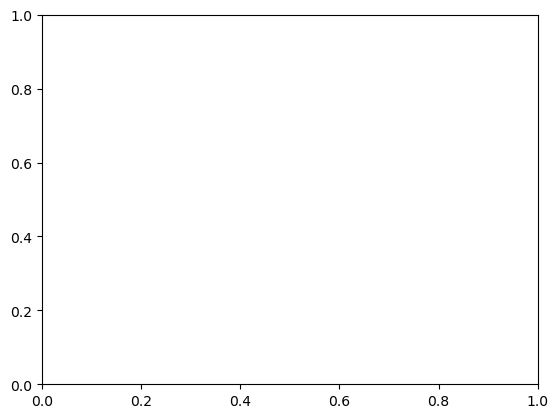

In [30]:
gdf = gpd.GeoDataFrame.from_features(aoi_geojson)
gdf = gdf.set_crs('epsg:4326')
gdf_proj = gdf.to_crs(epsg=32618)

f, ax = plt.subplots(1, 1)
with rasterio.open(tif_files[0]) as src:
    gdf_proj.plot(ax=ax, alpha=0.5) # AOI used for search
    ctx.add_basemap(ax, crs='epsg:32618', source=ctx.providers.CartoDB.Positron)
    rasterio.plot.show(src, ax=ax, alpha=0.6) # Resulting asset from the search
    plt.show()

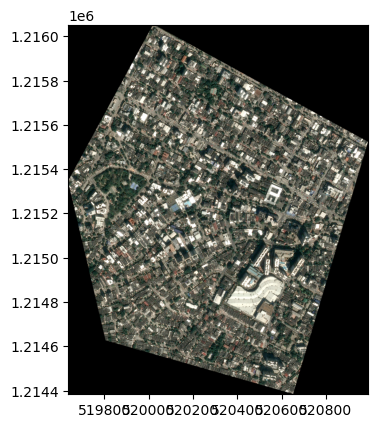

<AxesSubplot: >

In [32]:
# Read raster file with rasterio
raster = rasterio.open(tif_files[0])
rasterio.plot.show(raster)